In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import joblib
import pickle

from imblearn.over_sampling import ADASYN
from sklearn.utils import shuffle
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, f1_score, recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from model import cal_score, read_data

In [50]:
import sys
sys.version
print(sys.executable)

C:\Users\cheng\anaconda3\envs\mds\python.exe


In [22]:
DATA_ROOT = 'data/'
continuous_col = ['publand', 'robbery', 'urban_proj', 'monitor', 'idle', 'school', 'park', 'mrt', 'rob', ]
binary_col = ['DistanceType1_School', 'DistanceType1_Park',
                  'DistanceType1_MRT', 'DistanceType1_ROB', 
                  'DistanceType2_School', 'DistanceType2_Park', 
                  'DistanceType2_MRT', 'DistanceType2_ROB',
                  'MonitorType1', 'MonitorType2',]
mix_col = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 
               'Feature5', 'Feature6', 'Feature7', 'Feature8']
target_col = ['output']

all_col = continuous_col + binary_col + mix_col

In [13]:
feature_set = [all_col, mix_col, continuous_col]

In [23]:
1 / np.geomspace(1e-6, 1e-2, 15)

array([1.00000000e+06, 5.17947468e+05, 2.68269580e+05, 1.38949549e+05,
       7.19685673e+04, 3.72759372e+04, 1.93069773e+04, 1.00000000e+04,
       5.17947468e+03, 2.68269580e+03, 1.38949549e+03, 7.19685673e+02,
       3.72759372e+02, 1.93069773e+02, 1.00000000e+02])

C:\Users\cheng\anaconda3\envs\mds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\cheng\anaconda3\envs\mds\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cheng\anaconda3\envs\mds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\che

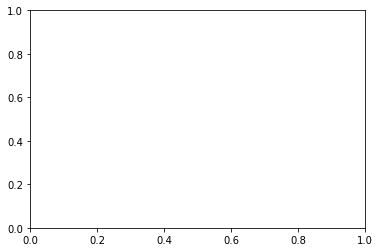

In [57]:

records = pd.DataFrame()
for TARGET in ['bicycle', 'home']:
    raw_df = pd.read_csv(os.path.join(DATA_ROOT, f'{TARGET}.csv'))
    raw_df = raw_df.rename(columns={'Feature1 ': 'Feature1'})
    if 'STD_monitor ' in raw_df.columns:
        raw_df = raw_df.rename(columns={'STD_monitor ': 'STD_monitor'})
    X = raw_df[continuous_col + binary_col + mix_col]
    y = raw_df[target_col]
    X, y = shuffle(X, y, random_state=0)
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    scaler = StandardScaler()
    scaled_x = scaler.fit_transform(x_train)
    x_train = pd.DataFrame(scaled_x, columns=x_train.columns, index=x_train.index)
#     x_train = pd.concat([
#         scaled_df,
#         x_train[std_col]
#     ], axis=1, join='inner')

    scaled_x = scaler.fit_transform(x_test)
    x_test = pd.DataFrame(scaled_x, columns=x_test.columns, index=x_test.index)
    
    # tuning
    kernels = ['rbf']
    c_range = 1 / np.geomspace(1e-6, 1e-2, 15)
    parameters = {'kernel': kernels, 'C': c_range}
    start_time = time.perf_counter()
    gs = GridSearchCV(SVC(random_state=1), param_grid=parameters, scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'],
                    refit='f1', cv=5, return_train_score=True)
    gs.fit(x_train, y_train.to_numpy().ravel())
    end_time = time.perf_counter()
    cv_dict = {}
    for key in gs.cv_results_:
        if type(gs.cv_results_[key]) == list:
            cv_dict[key] = gs.cv_results_[key]
        else:
            cv_dict[key] = gs.cv_results_[key].tolist()
    with open(f'{TARGET}.json', 'w', encoding='utf8') as fp:
        json.dump(cv_dict, fp)
    y_pred = gs.predict(x_test)
    record = gs.best_params_
    record['target'] = TARGET
    record['f1'] = f1_score(y_test, y_pred)
    record['precision'] = precision_score(y_test, y_pred)
    record['recall'] = recall_score(y_test, y_pred)
    record['auc'] = roc_auc_score(y_test, y_pred)
    record['accuracy'] = accuracy_score(y_test, y_pred)
    record['search_time'] = end_time - start_time
    metric = confusion_matrix(y_test, y_pred)
    _ = plt.subplot()
    sns.heatmap(metric, square=True, annot=True, cbar=False, fmt='d')
    plt.xlabel("predict value")
    plt.ylabel("true value")
    plt.title("confusion matrix")
    plt.tight_layout()
    plt.savefig(f'{TARGET}_confusion.png')
    plt.close()

    _ = plt.subplot()
    plot_roc_curve(gs, x_test, y_test)
    plt.tight_layout()
    plt.savefig(f'{TARGET}_roc.png')
    plt.close()
    
    heat_df = pd.DataFrame(index=c_range, columns=kernels)
    for i, params in enumerate(gs.cv_results_['params']):
        heat_df.loc[params['C'], params['kernel']] = gs.cv_results_['mean_test_f1'][i]    
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 20))
    sns.heatmap(heat_df.astype('float64'), square=False, annot=True, cbar=True, fmt='.3f', cmap="coolwarm")
    plt.xlabel("kernel")
    plt.ylabel("C")
    plt.yticks(np.arange(1, len(c_range) + 1) - 0.5, [round(cc, 3) for cc in c_range], )
    plt.tight_layout()
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.savefig(f'{TARGET}_tuning.png')
    plt.close()
    records = records.append(record, ignore_index=True)
    
    final_model = SVC(kernel=gs.best_params_['kernel'], C=gs.best_params_['C'], probability=True)
    final_model.fit(X, y)
    joblib.dump(final_model, f'svm/{TARGET}.joblib')
    
    
records.to_csv('SVM_record.csv', index=False)

### 額外的處理
- 'Feature1 ' 改成 'Feature1'

### 問題
- address、lat、lng 文字是否存留
- 是否都標準化
- publand 那些要標準化不知道 tarin test split 的方式
- 佳妤寶寶的 read_data 沒有欄位名，可能有些模型也不能吃欄位名，但是這樣我們就要非常確定每次不論訓練還是真實測試的時候，欄位的順序沒有變過

## CART

In [114]:
def report(gs, result, scoring, x_train, y_train, search_time, model_name, theft_type, parameter=None):
    feature_names = pd.read_csv(os.path.join(DATA_ROOT, f'{theft_type}.csv')).drop(columns=['output']).columns
    def plot_metric(metric, ax, cart_result):
        markers, caps, bars = ax.errorbar(ccp_alphas, cart_result.cv_results_[f'mean_train_{metric}'], 
                                          cart_result.cv_results_[f'std_train_{metric}'], 
                                          label=f'training', ecolor='skyblue')
        [bar.set_alpha(1) for bar in bars]
        markers, caps, bars = ax.errorbar(ccp_alphas, cart_result.cv_results_[f'mean_test_{metric}'],
                                          cart_result.cv_results_[f'std_test_{metric}'], 
                                          label=f'validation', ecolor='orange', color='salmon')
        [bar.set_alpha(0.7) for bar in bars]
        best_id = cart_result.cv_results_[f'mean_test_{metric}'].argmax()
        best_metric = cart_result.cv_results_[f'mean_test_{metric}'][best_id]
        ax.scatter(ccp_alphas[best_id], best_metric, 
                    color='r', s=30, zorder=5)
        t = ax.text(ccp_alphas[best_id] + 0.001, best_metric - 0.05, 
                    f'alpha={ccp_alphas[best_id]: .4f}', fontsize=12)
        t.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
        ax.legend(loc='best')
        ax.set_title(f'{metric.capitalize()} v.s. alpha')
        ax.set_xlabel('alpha')
        ax.set_ylabel(metric)

    def plot_cv(result, scoring):
        fig, axes = plt.subplots(2, 3, figsize=(18, 8))
        axes = axes.ravel()
        for i in range(5):
            ax = axes[i]
            plot_metric(scoring[i], ax, result)

        plt.tight_layout()
        fig.delaxes(axes[5])
        plt.savefig(f'{model_name}_{theft_type}_cv.png', dpi=200)
        print('以 10 validation 的平均值繪製折線圖，折線圖上下的直條總共是兩單位標準差')
        
    def get_grids(parameter, result):
        grids = pd.DataFrame(columns=parameter['n_estimators'])
        grids['alpha'] = parameter['ccp_alpha']
        grids = grids.set_index('alpha')
        for i, key in enumerate(result.cv_results_['params']):
            grids.loc[key['ccp_alpha'], key['n_estimators']] = result.cv_results_['mean_test_f1'][i]
        fig, ax = plt.subplots(figsize=(15,20)) 
        sns.heatmap(result.cv_results_['mean_test_f1'].reshape(len(parameter['ccp_alpha']), len(parameter['n_estimators'])), 
                    cmap="RdBu_r", annot=True, fmt="0.3f", 
                    yticklabels=parameter['ccp_alpha'],
                    xticklabels=parameter['n_estimators'])
        plt.xlabel('n_estimators')
        plt.ylabel('ccp_alpha')
        plt.savefig(f'{model_name}_{theft_type}.png', dpi=200)

    def show_cv(gs, result, scoring, x_train, y_train, search_time):
        print(f'Best hyperparameter: {result.best_params_}')
        best_id = result.best_index_
        record = {'search_time': search_time}
        for metric in scoring:
            print(f'{metric} in validation: mean={result.cv_results_[f"mean_test_{metric}"][best_id]}, std={result.cv_results_[f"std_test_{metric}"][best_id]}')
            record[f'{metric}_mean'] = result.cv_results_[f"mean_test_{metric}"][best_id]
            record[f'{metric}_std'] = result.cv_results_[f"std_test_{metric}"][best_id]
        if 'n_estimators' in result.best_params_:
            rf = RandomForestClassifier(ccp_alpha=result.best_params_['ccp_alpha'], n_estimators=result.best_params_['n_estimators'])
            rf.fit(x_train, y_train)
            y_pred = rf.predict(X_test)
            metric = confusion_matrix(y_test, y_pred)
            print(f'Depth: mean={np.mean([estimator.tree_.max_depth for estimator in rf.estimators_])}, std={np.std([estimator.tree_.max_depth for estimator in rf.estimators_])}')
            print(f'Number of nodes: mean={np.mean([estimator.tree_.node_count for estimator in rf.estimators_])}, std={np.std([estimator.tree_.node_count for estimator in rf.estimators_])}')
            print(f'Number of leaves: mean={np.mean([estimator.tree_.n_leaves for estimator in rf.estimators_])}, std={np.std([estimator.tree_.n_leaves for estimator in rf.estimators_])}')
            record['depth_mean'] = np.mean([estimator.tree_.max_depth for estimator in rf.estimators_])
            record['depth_std'] = np.std([estimator.tree_.max_depth for estimator in rf.estimators_])
            record['node_mean'] = np.mean([estimator.tree_.node_count for estimator in rf.estimators_])        
            record['node_std'] = np.std([estimator.tree_.node_count for estimator in rf.estimators_])
            record['leaf_mean'] = np.mean([estimator.tree_.n_leaves for estimator in rf.estimators_])
            record['leaf_std'] = np.std([estimator.tree_.n_leaves for estimator in rf.estimators_])
            model = RandomForestClassifier(ccp_alpha=result.best_params_['ccp_alpha'], n_estimators=result.best_params_['n_estimators'])
            
            importances = rf.feature_importances_
            std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
            forest_importances = pd.Series(importances, index=feature_names)
            fig, ax = plt.subplots()
            forest_importances.plot.bar(yerr=std, ax=ax)
            ax.set_title("Feature importances using MDI")
            ax.set_ylabel("Mean decrease in impurity")
            fig.tight_layout()
            plt.savefig(f'rf_{theft_type}_importance.png')
            
            result = permutation_importance(
                rf, X_test, y_test, n_repeats=10, random_state=42
            )  # , n_jobs=0
            forest_importances = pd.Series(result.importances_mean, index=feature_names)
            fig, ax = plt.subplots()
            forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
            ax.set_title("Feature importances using permutation on full model")
            ax.set_ylabel("Mean accuracy decrease")
            fig.tight_layout()
            plt.savefig(f'rf_{theft_type}_permutation.png')
            
            model.fit(np.concatenate([X_train, X_test], axis=0), np.concatenate([y_train, y_test], axis=0))
            joblib.dump(model, f'{model_name}_{theft_type}.pkl')
                      
        else:
            cart = DecisionTreeClassifier(ccp_alpha=result.best_params_['ccp_alpha'])
            record['ccp_alpha'] = result.best_params_['ccp_alpha']
            cart.fit(x_train, y_train)
            y_pred = cart.predict(X_test)
            metric = confusion_matrix(y_test, y_pred)
            print(f'Depth: {cart.tree_.max_depth}')
            print(f'Number of nodes: {cart.tree_.node_count}')
            print(f'Number of leaves: {cart.tree_.n_leaves}')
            record['depth'] = cart.tree_.max_depth
            record['node'] = cart.tree_.node_count
            record['leaf'] = cart.tree_.n_leaves
            model = DecisionTreeClassifier(ccp_alpha=result.best_params_['ccp_alpha'])
            
            importances = cart.feature_importances_
            draw_df = pd.DataFrame(index=feature_names)
            draw_df['MDI'] = importances

            result = permutation_importance(
                cart, X_test, y_test, n_repeats=10, random_state=42
            )  # , n_jobs=0
            draw_df['permutation'] = result.importances_mean
            draw_df = draw_df.sort_values(by=['MDI'], ascending = False)

            plt.style.use('seaborn')
            fig, ax = plt.subplots(figsize=(18, 6))
            fig.patch.set_alpha(0)
            plt.title("Feature importances", fontsize=18)

            bar1 = draw_df.MDI.plot(kind='bar', ax=ax, color='salmon', label='MDI', position=1, width=0.35)
            ax.set_ylabel("Mean decrease in impurity", color='salmon', fontsize=15)
            ax.tick_params(axis='y', labelcolor='salmon')
            ax.legend(loc='upper left', fontsize=15)

            ax2 = ax.twinx()
            draw_df.permutation.plot(kind='bar', ax=ax2, label='permutation', color='teal', position=0, width=0.35)
            ax2.set_ylabel("Mean accuracy decrease", color='teal', fontsize=15)
            ax2.tick_params(axis='y', labelcolor='teal')
            ax2.legend(fontsize=15)
            ax.set_xticklabels(draw_df.index, rotation=30, ha='right')

            plt.xlim(-1, len(feature_names))
            ax.set_ylim(0, 0.2)
            ax2.set_ylim(0, 0.22)

            plt.xticks(rotation=30, ha='right')
            fig.tight_layout()
            plt.savefig(f'cart_{theft_type}_feature.png', dpi=200)
            
            model.fit(np.concatenate([X_train, X_test], axis=0), np.concatenate([y_train, y_test], axis=0))
            joblib.dump(model, f'{model_name}_{theft_type}.joblib')
        
        return metric, y_pred, record, model

    def show_confusion(metric, y_test, y_pred, record):
        fig, ax = plt.subplots(figsize=(7, 7))
        sns.heatmap(metric, square=True, annot=True, fmt='d', cbar=False, annot_kws={"size":15})
        plt.xlabel("predict value", fontsize=15)
        plt.ylabel("true value", fontsize=15)
        ax.xaxis.set_ticklabels(['safe', 'theft'], fontsize=13)
        ax.yaxis.set_ticklabels(['safe', 'theft'], fontsize=13)
        if len(model_name) > 4:
            name = ' '.join(map(str.capitalize, model_name.split('_')))
        else:
            name = model_name.upper()
        plt.title(f"{name} with {theft_type} data", fontsize=17)
        plt.savefig(f'{model_name}_{theft_type}_confusion.png', dpi=200)
        f1, accuracy, precision, recall, auc = cal_score(y_test, y_pred)
        record['f1'] = f1
        record['accuracy'] = accuracy
        record['precision'] = precision
        record['recall'] = recall
        record['roc_auc'] = auc
        print("report:\n",classification_report(y_test, y_pred)) 
        pd.DataFrame(record, index=range(1)).to_csv(f'{model_name}_{theft_type}.csv', index=False)
    
    if model_name == 'cart':
        plot_cv(result, SCORING)
    else:
        get_grids(parameter, result)
    metric, y_pred, record, model = show_cv(gs, result, SCORING, X_train, y_train, search_time)
    show_confusion(metric, y_test, y_pred, record)
    return model

In [116]:
theft_type = 'home'
X_train, X_test, y_train, y_test = read_data(DATA_ROOT, theft_type)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [117]:
start_time = time.perf_counter()
parameter = {'ccp_alpha': ccp_alphas, }
SCORING = ['accuracy', 'f1', 'recall', 'roc_auc', 'precision'] 
cart_gs = GridSearchCV(DecisionTreeClassifier(), param_grid=parameter, cv=10, scoring=SCORING, 
                       refit='f1', return_train_score=True)
cart_result = cart_gs.fit(X_train, y_train)
search_time = time.perf_counter() - start_time

In [49]:
def cal_score(y_test, y_pred):

    # metric = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    return f1, accuracy, precision, recall, auc

以 10 validation 的平均值繪製折線圖，折線圖上下的直條總共是兩單位標準差
Best hyperparameter: {'ccp_alpha': 0.00018878667106170014}
accuracy in validation: mean=0.7892457581480723, std=0.0243527103535469
f1 in validation: mean=0.7890260164002771, std=0.025236710563925863
recall in validation: mean=0.788243251459144, std=0.03280271851182916
roc_auc in validation: mean=0.791766804403738, std=0.025148030514375
precision in validation: mean=0.7903884522306797, std=0.02517124234586085
Depth: 25
Number of nodes: 1405
Number of leaves: 703
report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78       644
           1       0.78      0.79      0.78       640

    accuracy                           0.78      1284
   macro avg       0.78      0.78      0.78      1284
weighted avg       0.78      0.78      0.78      1284



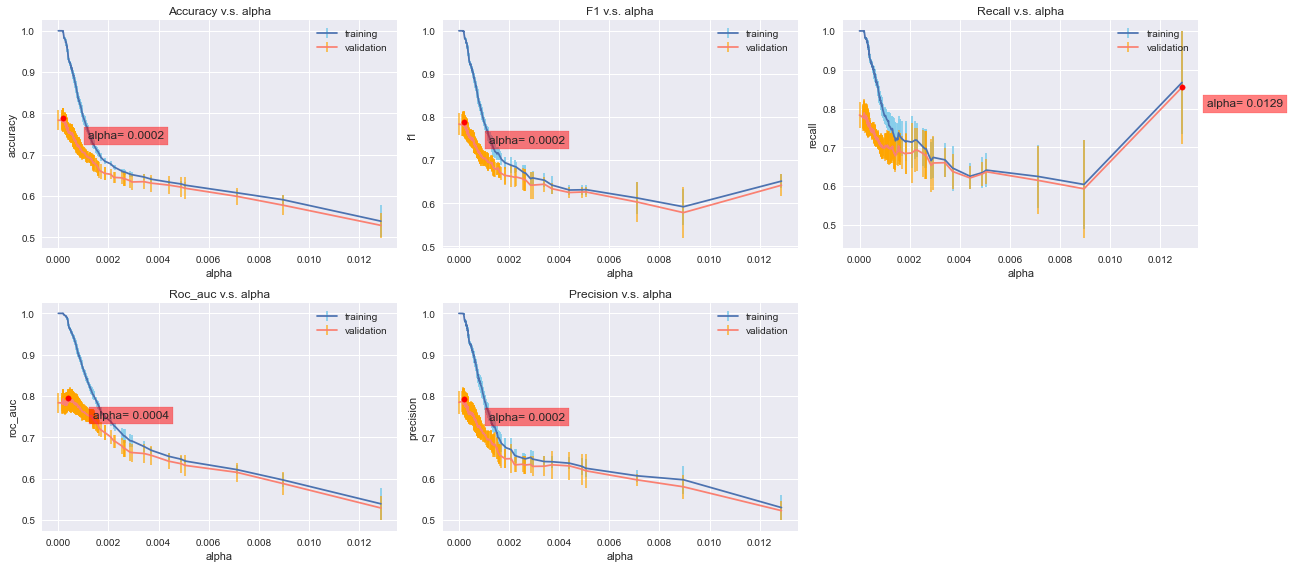

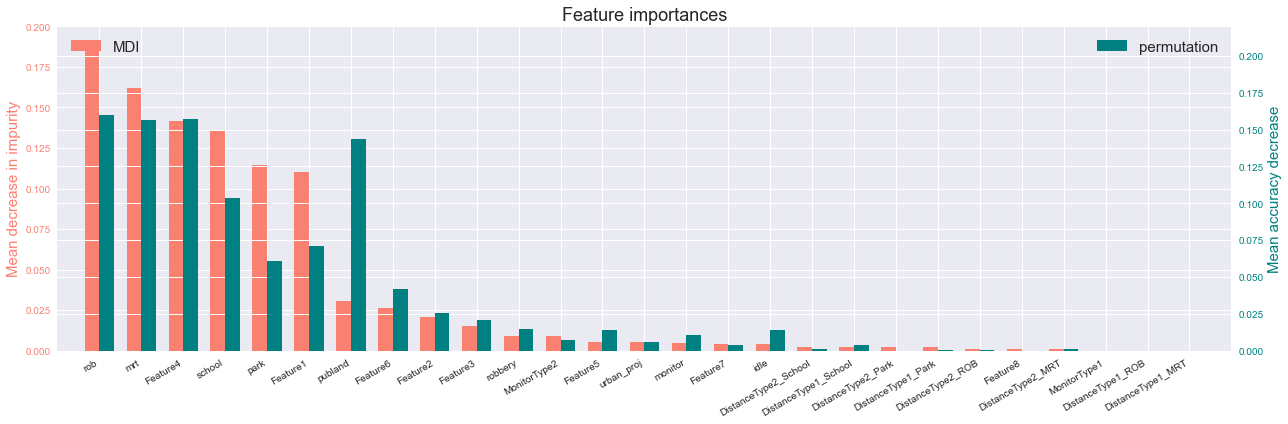

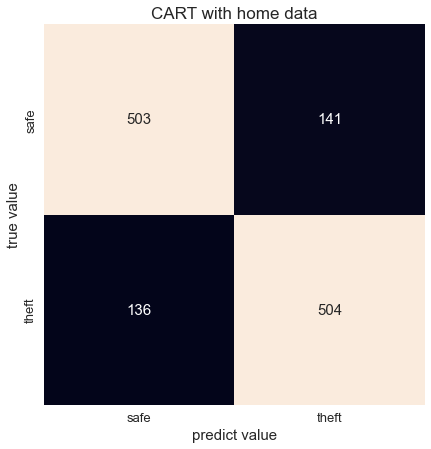

In [118]:
model = report(cart_gs, cart_result, SCORING, X_train, y_train, search_time, 'cart', theft_type)

In [51]:
joblib.load(f'cart_{theft_type}.joblib')

DecisionTreeClassifier(ccp_alpha=0.0002559597910437343)

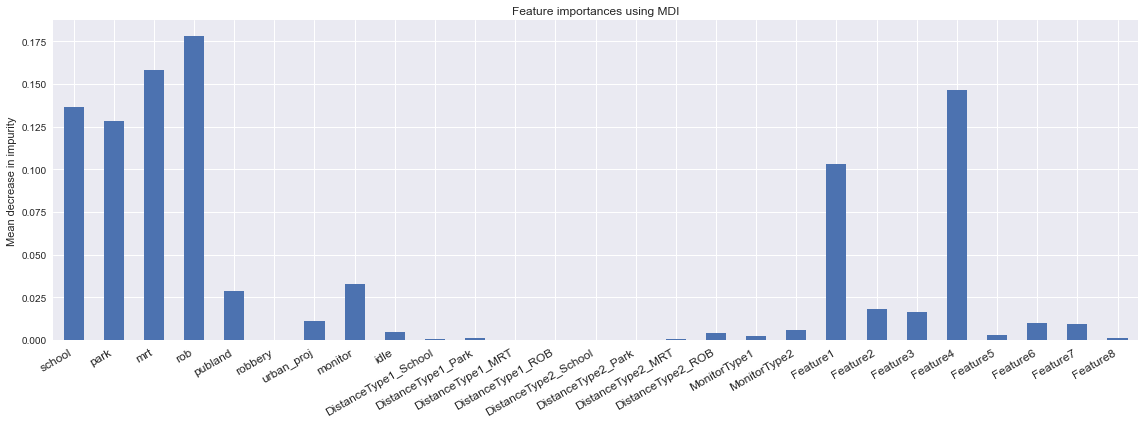

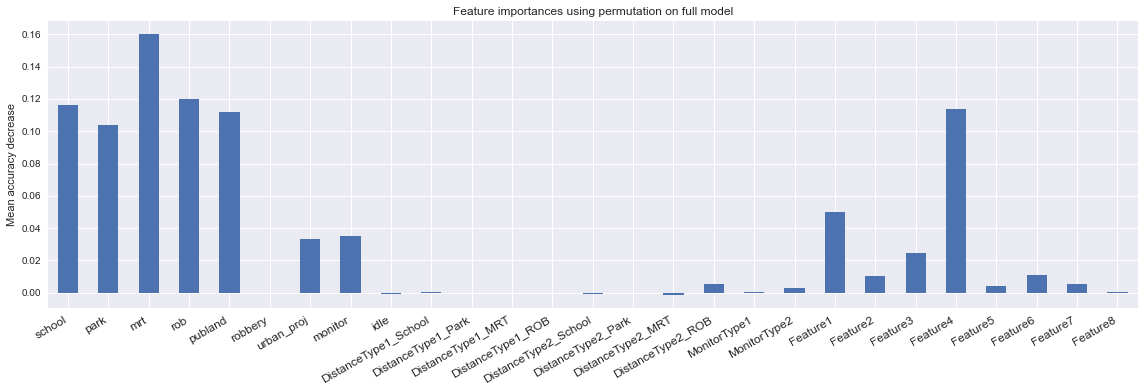

In [116]:
theft_type = 'home'
cart = joblib.load(os.path.join('cart', f'cart_{theft_type}.joblib'))
feature_names = pd.read_csv(os.path.join(DATA_ROOT, f'{theft_type}.csv')).drop(columns=['output']).columns
            
importances = cart.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots(figsize=(16, 6))
forest_importances.plot.bar(ax=ax)
plt.style.use('seaborn')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=30, ha='right', fontsize=12)
fig.tight_layout()
plt.savefig(f'cart_{theft_type}_importance.png')

result = permutation_importance(
    cart, X_test, y_test, n_repeats=10, random_state=42
)  # , n_jobs=0
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots(figsize=(16, 6))
plt.style.use('seaborn')
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.savefig(f'cart_{theft_type}_permutation.png')


## 重新訓練 SVM（已知最佳超參數）

In [69]:
theft_type = 'bicycle'
with open(f'svm/{theft_type}.json') as f:
    results = json.loads(f.read())

In [70]:
best_id = np.argmin(results['rank_test_f1'])
best_c = results['param_C'][best_id]

#### 畫 confusion

In [71]:

X_train, X_test, y_train, y_test = read_data(DATA_ROOT, theft_type)
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

In [72]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

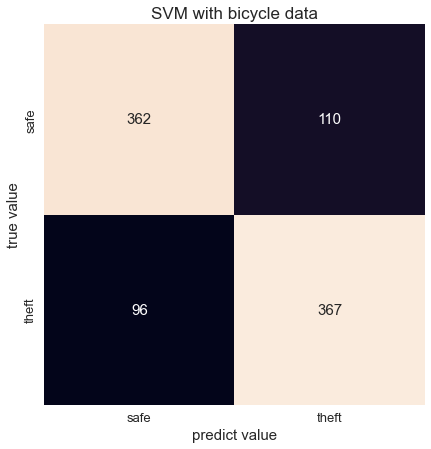

In [73]:
model_name = 'svm'
# model = RandomForestClassifier(ccp_alpha=, n_estimators=)
model = SVC(kernel='rbf', C=best_c)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
metric = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(metric, square=True, annot=True, fmt='d', cbar=False, annot_kws={"size":15})
plt.xlabel("predict value", fontsize=15)
plt.ylabel("true value", fontsize=15)
ax.xaxis.set_ticklabels(['safe', 'theft'], fontsize=13)
ax.yaxis.set_ticklabels(['safe', 'theft'], fontsize=13)
if len(model_name) > 4:
    name = ' '.join(map(str.capitalize, model_name.split('_')))
else:
    name = model_name.upper()
plt.title(f"{name} with {theft_type} data", fontsize=17)
plt.savefig(f'{model_name}_{theft_type}_confusion.png', dpi=200)

In [151]:
X = StandardScaler().fit_transform(X)

In [152]:
model = SVC(kernel='rbf', C=best_c)
model.fit(X, y)
joblib.dump(model, f'svm/{theft_type}.joblib')

['svm/bicycle.joblib']

## Tree plot

In [3]:
import graphviz

from sklearn import tree
from dtreeviz.trees import dtreeviz

In [18]:
theft_type = 'bicycle'
model_name = 'cart'
data_path = 'data/'
df = pd.read_csv(data_path + theft_type + '.csv')
y_df = df[['output']]
# drop 'address', 'district', 'output'
x_df = df.drop(columns=['output'])
# # 定義 X, y
X = np.array(x_df)
y = np.array(y_df).reshape(-1)
param = pd.read_csv(f'{model_name}/{model_name}_{theft_type}.csv')

model = DecisionTreeClassifier(ccp_alpha=param.loc[0, 'ccp_alpha'], max_depth=4)
model.fit(X, y)


DecisionTreeClassifier(ccp_alpha=0.0002452947997502, max_depth=4)

In [19]:
dot_data = tree.export_graphviz(model, out_file=None,
                                feature_names=x_df.columns,
                                filled=True)
graph = graphviz.Source(dot_data, format="png")
graph.render(f'{model_name}/{theft_type}_tree')
model = joblib.load(f'{model_name}/{model_name}_{theft_type}.joblib')
viz = dtreeviz(model, X, y,
                target_name="theft",
                feature_names=x_df.columns,
                depth_range_to_display=(0, 4))
viz.save(f'{model_name}/{theft_type}_tree2.svg')

## 熱力圖

In [99]:
theft_type = 'bicycle'
data_path = 'theft_raw/'
df = pd.read_csv(data_path + theft_type + '_coord.csv', encoding='big5', sep='\t')

In [100]:
df = df.rename(columns={'Response_Address': 'address', 'Response_X': 'lng', 'Response_Y': 'lat'})
df = df[['address', 'lat', 'lng']]

In [60]:
df['output'] = 1

In [42]:
import plotly.express as px

fig = px.density_mapbox(df, lat='lat', lon='lng', z='output'
                         
                        )
# center=dict(lat=0, lon=180),mapbox_style="stamen-terrain" , radius=10,zoom=0,

In [43]:
fig.write_html(f"{theft_type}_heat.html")

In [101]:
df = df[['lat', 'lng']]
df = df.dropna()

In [83]:
mrt = pd.read_csv('property/mrt.csv')
mrt_list = mrt[['lat', 'lng']].values.tolist()
school = pd.read_csv('property/school.csv')
school_list = school[['lat', 'lng']].values.tolist()
park = pd.read_csv('property/park.csv')
park_list = park[['lat', 'lng']].values.tolist()
rob = pd.read_csv('property/rob.csv')
rob_list = rob[['lat', 'lng']].values.tolist()

In [110]:

from folium import plugins, Map
from folium.plugins import MarkerCluster

m = Map(df.iloc[0, :].values, zoom_start=11)

# convert to (n, 2) nd-array format for heatmap
stationArr = df.values

# plot heatmap
m.add_child(plugins.HeatMap(stationArr, radius=15))

marker_cluster = MarkerCluster().add_to(m)

for point in range(0, len(mrt_list)):
    folium.Marker(mrt_list[point], popup=mrt['站名'][point] + '捷運站', icon=folium.Icon(color='orange', icon_color='white', icon='subway', prefix='fa')).add_to(marker_cluster)
m

for point in range(0, len(school_list)):
    folium.Marker(school_list[point], popup=school['school name'][point], icon=folium.Icon(color='darkblue', icon_color='white', icon='book', prefix='fa')).add_to(marker_cluster)
m

for point in range(0, len(park_list)):
    folium.Marker(park_list[point], popup=park['pm_name'][point], icon=folium.Icon(color='green', icon_color='white', icon='tree', prefix='fa')).add_to(marker_cluster)
m
for point in range(0, len(rob_list)):
    folium.Marker(rob_list[point], popup=rob['Response_Address'][point], icon=folium.Icon(color='darkred', icon_color='white', icon='exclamation', prefix='fa')).add_to(marker_cluster)
m

In [111]:
m.save(f'{theft_type}_heatmap_all.html')